In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import argparse
import csv
import os
import json
import sys
import pickle
import numpy as np
import pandas as pd
from os.path import join
from collections import defaultdict, deque
import itertools

## We trained one randomized agent on level 0-50

In [190]:
fpath = "log/random_log/train/args_run_00.json"
with open(fpath, 'r') as json_file:
    json_object = json.load(json_file)
print(json.dumps(json_object, indent=1))

{
 "distribution_mode": "easy",
 "env_name": "fruitbot",
 "num_levels": 50,
 "nupdates": 0,
 "run_id": 0,
 "start_level": 0,
 "test_worker_interval": 0,
 "total_tsteps": 500000
}


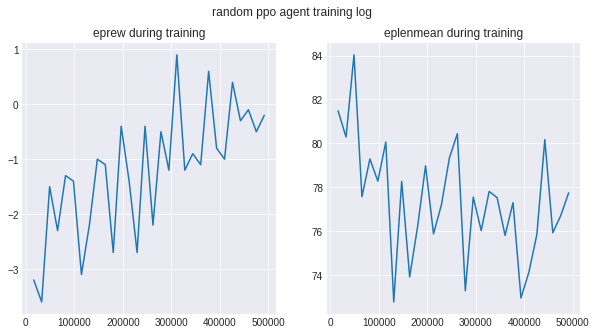

In [192]:
plot_compare_runs()

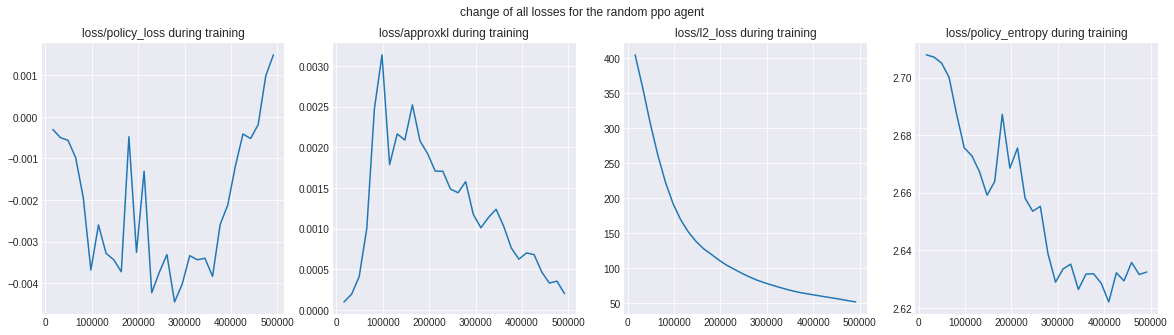

In [194]:
losses = ["loss/"+l for l in 
          ['policy_loss','approxkl', "l2_loss", "policy_entropy","fm_loss", 'value_loss']]
title="change of all losses for the random ppo agent"
plot_compare_runs(keys=losses[0:4], title=title)

## Below is one basic ppo agent trained on level 0~50

In [242]:
## log file LOST :(
# see plotter_1

### Below compares basic and randomized agents on same
### unseen level settings

In [228]:
fpath1, fpath2 = "log/vanilla/test/args_run_02.json", "log/random_log/test/args_run_02.json"
with open(fpath1, 'r') as json_file1:
    json_object1 = json.load(json_file1)
print(json.dumps(json_object1, indent=1))
with open(fpath2, 'r') as json_file2:
    json_object2 = json.load(json_file2)
print(json.dumps(json_object2, indent=1))

{
 "distribution_mode": "easy",
 "env_name": "fruitbot",
 "nrollouts": 50,
 "num_levels": 50,
 "run_id": 2,
 "start_level": 150,
 "total_timesteps": 100000
}
{
 "distribution_mode": "easy",
 "env_name": "fruitbot",
 "nrollouts": 50,
 "num_levels": 50,
 "run_id": 2,
 "start_level": 150,
 "total_timesteps": 100000
}


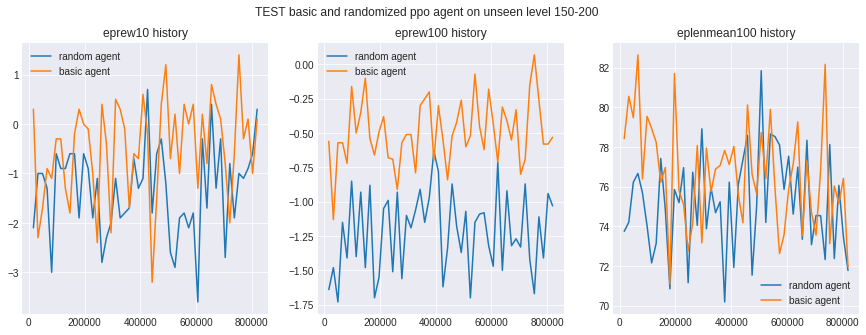

In [231]:
dirs = ["log/random_log/test/", 'log/vanilla/test/']
ids = [2,2]
plot_compare_agents(log_dirs=dirs, run_ids=ids, \
                  keys=['eprew10', 'eprew100', 'eplenmean100'],\
                  title="TEST basic and randomized ppo agent on unseen level 150-200")

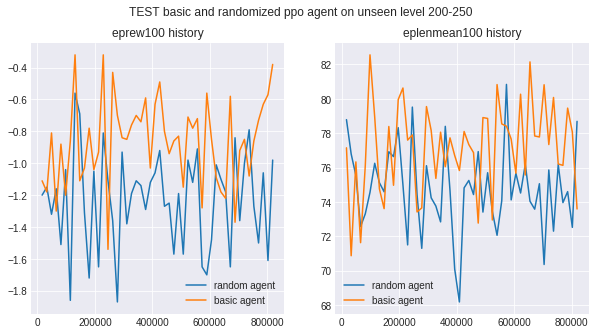

In [237]:
dirs = ["log/random_log/test/", 'log/vanilla/test/']
ids = [3,3]
plot_compare_agents(log_dirs=dirs, run_ids=ids, \
                  keys=['eprew100', 'eplenmean100'],\
                  title="TEST basic and randomized ppo agent on unseen level 200-250")

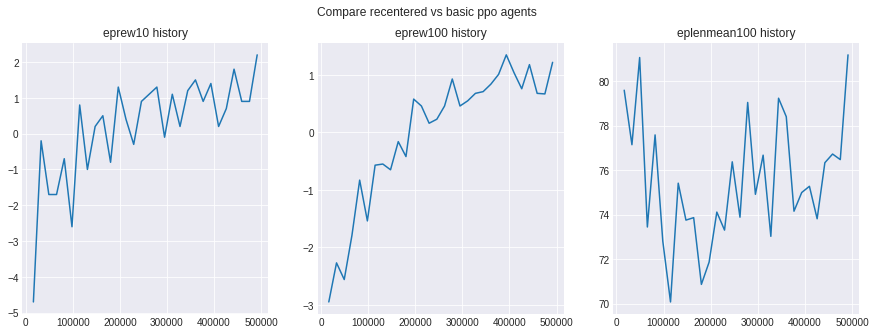

In [257]:
plot_compare_runs("log/recenter/train", run_ids=[1], \
                  keys=['eprew10','eprew100', 'eplenmean100'], \
                  title="Compare recentered vs basic ppo agents")

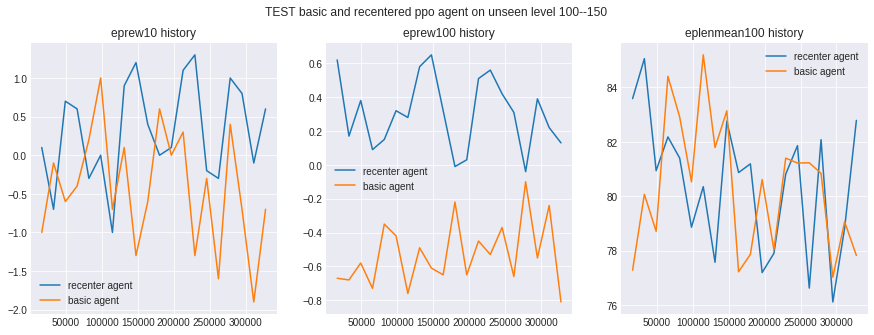

In [265]:
dirs = ["log/recenter/test/", 'log/vanilla/test/']
ids = [1,1]
paths = [join(_dir, "args_run_{}.json".format(str(_id).zfill(2))) for _dir, _id in zip(dirs, ids)]
with open(paths[0], 'r') as json_file1:
    json_object1 = json.load(json_file1)
with open(paths[1], 'r') as json_file2:
    json_object2 = json.load(json_file2)
assert json_object1["num_levels"] ==  json_object2["num_levels"]
assert json_object1["start_level"] == json_object2["start_level"]
start = json_object1["start_level"]
end = start + json_object1["num_levels"]
plot_compare_agents(log_dirs=dirs, run_ids=ids, \
                    legends=["recenter agent", "basic agent"],
                  keys=['eprew10', 'eprew100', 'eplenmean100'],\
                  title="TEST basic and recentered ppo agent on unseen level {}--{}".format(start, end))

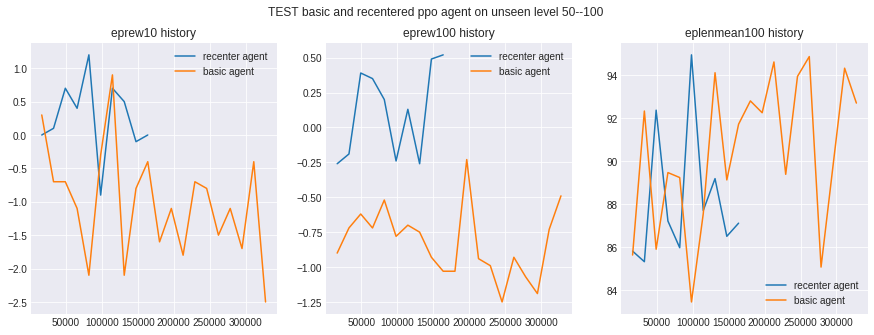

In [267]:
dirs = ["log/recenter/test/", 'log/vanilla/test/']
ids = [0,0]
paths = [join(_dir, "args_run_{}.json".format(str(_id).zfill(2))) for _dir, _id in zip(dirs, ids)]
with open(paths[0], 'r') as json_file1:
    json_object1 = json.load(json_file1)
with open(paths[1], 'r') as json_file2:
    json_object2 = json.load(json_file2)
assert json_object1["num_levels"] ==  json_object2["num_levels"]
assert json_object1["start_level"] == json_object2["start_level"]
start = json_object1["start_level"]
end = start + json_object1["num_levels"]
plot_compare_agents(log_dirs=dirs, run_ids=ids, \
                    legends=["recenter agent", "basic agent"],
                  keys=['eprew10', 'eprew100', 'eplenmean100'],\
                  title="TEST basic and recentered ppo agent on unseen level {}--{}".format(start, end))

In [259]:
json_object1["start_level"]

150

### Some visualization on how I recentered the frames

In [3]:
obs = []
name = "obs_env"
for i in range(3, 10):
    obs.append(plt.imread(name+str(i)+".jpg"))
len(obs)

7

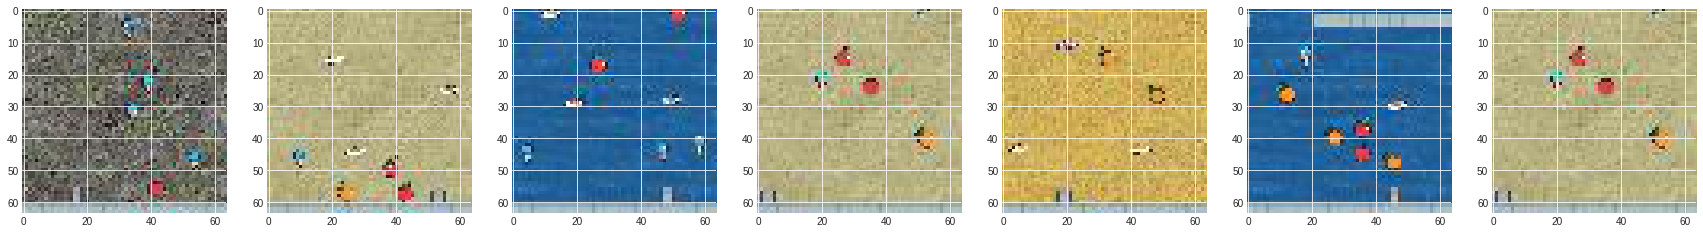

In [11]:
fig, axs = plt.subplots(1, len(obs), figsize=(30, 30*len(obs)))
for i in range(len(obs)):
    axs[i].imshow(obs[i])

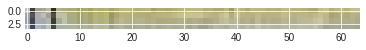

In [108]:
piece = obs[-1][:][57:57+4][:]
plt.imshow(piece)

In [109]:
piece.shape
piece = np.transpose(piece, (1,0,2))

In [110]:
bot = piece[2:5]
bot = np.transpose(bot, (1,0,2))

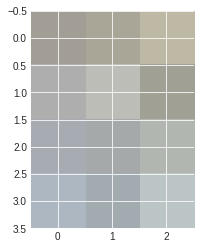

In [119]:
plt.imshow(bot) ## Target pixel values!! (4,5,3)

In [112]:
bot.shape

(4, 3, 3)

In [120]:
bot_norm = bot / np.linalg.norm(bot) ## Not hard-coded as global var!

In [179]:
def recenter(obs, bot_norm):
    recentered = []
    for i in range(obs.shape[0]): ## iterate through envs
        one_obs = obs[i]
        piece = np.transpose(one_obs[:][57:57+4][:], (1,0,2))
        bg = np.zeros((64*2, 64, 3), dtype=np.uint8)
        diff_min = 100
        loc_min = -1
        for loc in range(64-3):
            block = piece[loc:loc+3]
            block = np.transpose(block, (1,0,2))
            diff = abs(np.sum(bot_norm - block/np.linalg.norm(block)))
            if diff < diff_min:
                diff_min = diff
                loc_min = loc
        blk = piece[loc_min:loc_min+3]
        #print("detected loc: ", loc_min)
        center = 62 - loc_min
        bg[center:center+64] = one_obs.transpose((1,0,2))
        recentered.append(bg.transpose((1,0,2)))
    recentered = np.array(recentered)
    return recentered
    

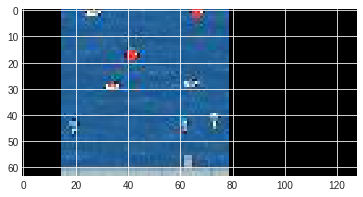

In [182]:
recentered = recenter(obs, bot_norm)
plt.imshow(recentered[2])

In [188]:
recentered[2].shape

(64, 128, 3)